In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from os import makedirs
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy import hstack
from numpy.random import randn
from numpy.random import randint
# from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import Constraint
from matplotlib import pyplot

from skimage import io

In [2]:
import tensorflow as tf


In [3]:
# from guppy_ornaments import load_limited as load_data

In [4]:
def generator(inputs,
              image_size,
              activation='sigmoid',
              labels=None,
              codes=None):
    """Build a Generator Model
    Stack of BN-ReLU-Conv2DTranpose to generate fake images.
    Output activation is sigmoid instead of tanh in [1].
    Sigmoid converges easily.
    # Arguments
        inputs (Layer): Input layer of the generator (the z-vector)
        image_size (int): Target size of one side (assuming square image)
        activation (string): Name of output activation layer
        labels (tensor): Input labels
        codes (list): 2-dim disentangled codes for InfoGAN
    # Returns
        Model: Generator Model
    """
    image_resize = image_size // 4
    # network parameters
    kernel_size = 4
    layer_filters = [128, 64, 32, 4]

    if labels is not None:
        if codes is None:
            # ACGAN labels
            # concatenate z noise vector and one-hot labels
            inputs = [inputs, labels]
        else:
            # infoGAN codes
            # concatenate z noise vector, one-hot labels and codes 1 & 2
            inputs = [inputs, labels] + codes
        x = concatenate(inputs, axis=1)
    elif codes is not None:
        # generator 0 of StackedGAN
        inputs = [inputs, codes]
        x = concatenate(inputs, axis=1)
    else:
        # default input is just 100-dim noise (z-code)
        x = inputs

    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = BatchNormalization()(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = UpSampling2D(size=2)(x)
        x = Conv2D(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation(activation)(x)

#     if activation is not None:
#         x = Activation(activation)(x)

    # generator output is the synthesized image x
    return Model(inputs, x, name='generator')


def discriminator(inputs,
                  activation='sigmoid',
                  num_labels=13,
                  num_codes=None):
    """Build a Discriminator Model
    Stack of LeakyReLU-Conv2D to discriminate real from fake
    The network does not converge with BN so it is not used here
    unlike in [1]
    # Arguments
        inputs (Layer): Input layer of the discriminator (the image)
        activation (string): Name of output activation layer
        num_labels (int): Dimension of one-hot labels for ACGAN & InfoGAN
        num_codes (int): num_codes-dim Q network as output 
                    if StackedGAN or 2 Q networks if InfoGAN
                    
    # Returns
        Model: Discriminator Model
    """
    kernel_size = 4
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.25)(x)

    x = Flatten()(x)
    # default output is probability that the image is real
    output = Dense(1)(x)
    if activation is not None:
        print(activation)
        output = Activation(activation)(output)
    
    outputs = []
    outputs.append(output)
    if num_labels:
        # ACGAN and InfoGAN have 2nd output
        # 2nd output is 10-dim one-hot vector of label
        layer = Dense(layer_filters[-2])(x)
        labels = Dense(num_labels)(layer)
        labels = Activation('softmax', name='label')(labels)
        outputs.append(labels)
        for code_i in range(num_codes):
        # InfoGAN have 3rd and 4th outputs
        # 3rd output is 1-dim continous Q of 1st c given x
            code = Dense(1)(layer)
            code = Activation('sigmoid', name='code{}'.format(code_i))(code)
            outputs.append(code)
    
    elif num_codes is not None:
        # StackedGAN Q0 output
        # z0_recon is reconstruction of z0 normal distribution
        z0_recon =  Dense(num_codes)(x)
        z0_recon = Activation('tanh', name='z0')(z0_recon)
        outputs.append(z0_recon)
        
    return Model(inputs, outputs, name='discriminator')


def train(models, x_train, params):
    """Train the Discriminator and Adversarial Networks
    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly real and fake images.
    Adversarial is trained next with fake images pretending to be real
    Generate sample images per save_interval.
    # Arguments
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters
    """
    # the GAN models
    generator, discriminator, adversarial = models
    # network parameters
    batch_size, latent_size, train_steps, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # number of elements in train dataset
    train_size = x_train.shape[0]
    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # generate fake images from noise using generator 
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # generate fake images
        fake_images = generator.predict(noise)
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0
        # since the discriminator weights are frozen in adversarial network
        # only the generator is trained
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False

            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        show=show,
                        step=(i + 1),
                        model_name=model_name)
            generator.save(model_name + ".h5")
   
    # save the model after training the generator
    # the trained generator can be reloaded for future MNIST digit generation
    generator.save(model_name + ".h5")

    
def generate_samples(images, model_name):
    os.makedirs(model_name+'_samples', exist_ok=True)
    for step in range(len(images)):
        filename = os.path.join(model_name+'_samples', "%05d.png" % step)
        image = images[step]
        io.imsave(filename, image)


def plot_images(generator,
                noise_input,
                noise_label=None,
                noise_codes=None,
                show=False,
                step=0,
                model_name="gan",
                gen_samples=None):
    """Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid
    # Arguments
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name
    """
    
        
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    rows = int(math.sqrt(noise_input.shape[0]))
    if noise_label is not None:
        noise_input = [noise_input, noise_label]
        if noise_codes is not None:
            noise_input += noise_codes

    images = generator.predict(noise_input)
    if gen_samples:
        generate_samples(images, model_name)
    else:
        plt.figure(figsize=(10, 10))
        num_images = images.shape[0]
        image_size = images.shape[1]
        for i in range(num_images):
            plt.subplot(rows, rows, i + 1)
            image = np.reshape(images[i], [image_size, image_size, 4])
            plt.imshow(image)
            plt.axis('off')
        plt.savefig(filename)
        if show:
            plt.show()
        else:
            plt.close('all')

def test_generator(generator):
    noise_input = np.random.uniform(-0.5, 0.5, size=[16, 100])
    plot_images(generator,
                noise_input=noise_input,
                show=True,
                model_name="test_outputs")

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
# from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

import numpy as np
import argparse

import sys
sys.path.append("..")


# from ..lib import gan

def train(models, data, params, num_codes=2):
    """Train the Discriminator and Adversarial networks
    Alternately train discriminator and adversarial networks by batch.
    Discriminator is trained first with real and fake images,
    corresponding one-hot labels and continuous codes.
    Adversarial is trained next with fake images pretending to be real,
    corresponding one-hot labels and continous codes.
    Generate sample images per save_interval.
    # Arguments
        models (Models): Generator, Discriminator, Adversarial models
        data (tuple): x_train, y_train data
        params (tuple): Network parameters
    """
    # the GAN models
    generator, discriminator, adversarial = models
    # images and their one-hot labels
    x_train, y_train = data
    # network parameters
    batch_size, latent_size, train_steps, num_labels, model_name = params
    print(num_labels)
    # the generator image is saved every 500 steps
    save_interval = 100
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # random class labels and codes
    noise_label = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    
    noise_codes = [np.random.normal(scale=0.5, size=[16, 1]) for i in range(num_codes)]
#     noise_code1 = np.random.normal(scale=0.5, size=[16, 1])
#     noise_code2 = np.random.normal(scale=0.5, size=[16, 1])
    # number of elements in train dataset
    train_size = x_train.shape[0]
    print(model_name,
          "Labels for generated images: ",
          np.argmax(noise_label, axis=1))

    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images and corresponding labels from dataset 
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]
        # random codes for real images
        
        inputs = []
        # generate fake images, labels and codes
        inputs.append(np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size]))
        inputs.append(np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)])
        fake_codes = []
        for j in range(num_codes):
            fc = np.random.normal(scale=0.5, size=[batch_size, 1])
            inputs.append(fc)
            fake_codes.append(fc)
#         fake_codes = [np.random.normal(scale=0.5, size=[batch_size, 1]) for i in range(num_codes)]
#         fake_code1 = np.random.normal(scale=0.5, size=[batch_size, 1])
#         fake_code2 = np.random.normal(scale=0.5, size=[batch_size, 1])
#         inputs = [noise, fake_labels, fake_codes]
        fake_images = generator.predict(inputs)

        # real + fake images = 1 batch of train data
        outputs = []
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0
        outputs.append(y)
        

        x = np.concatenate((real_images, fake_images))
#         labels = np.concatenate((real_labels, fake_labels))
        outputs.append(np.concatenate((real_labels, fake_labels)))
        for k in range(num_codes):
            real_code = np.random.normal(scale=0.5, size=[batch_size, 1])
            outputs.append(np.concatenate((real_code, fake_codes[k])))
#         real_codes = [np.random.normal(scale=0.5, size=[batch_size, 1]) for i in range(num_codes)]
#         real_code1 = np.random.normal(scale=0.5, size=[batch_size, 1])
#         real_code2 = np.random.normal(scale=0.5, size=[batch_size, 1])
#         codes = np.concatenate([(real_code, fake_code) for real_code, fake_code in zip(real_codes, fake_codes)])
#         codes1 = np.concatenate((real_code1, fake_code1))
#         codes2 = np.concatenate((real_code2, fake_code2))

        # label real and fake images
        # real images label is 1.0
        
        # fake images label is 0.0
#         y[batch_size:, :] = 0

        # train discriminator network, log the loss and label accuracy
#         outputs = [y, labels, codes]
        # metrics = ['loss', 'activation_1_loss', 'label_loss',
        # 'code1_loss', 'code2_loss', 'activation_1_acc',
        # 'label_acc', 'code1_acc', 'code2_acc']
        # from discriminator.metrics_names
        metrics = discriminator.train_on_batch(x, outputs)
        fmt = "%d: [discriminator loss: %f, label_acc: %f]"
        log = fmt % (i, metrics[0], metrics[6])

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0 and
        # corresponding one-hot label or class + random codes
        # since the discriminator weights are frozen in adversarial network
        # only the generator is trained
        # generate fake images, labels and codes
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
#         fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
#                                                           batch_size)]
#         fake_code1 = np.random.normal(scale=0.5, size=[batch_size, 1])
#         fake_code2 = np.random.normal(scale=0.5, size=[batch_size, 1])
        # label fake images as real
        y = np.ones([batch_size, 1])

        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and label accuracy
        inputs = [noise, fake_labels] + [fake_code for fake_code in fake_codes]
        outputs = [y, fake_labels] + [fake_code for fake_code in fake_codes]
        metrics  = adversarial.train_on_batch(inputs, outputs)
        fmt = "%s [adversarial loss: %f, label_acc: %f]"
        log = fmt % (log, metrics[0], metrics[6])

        print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False
    
            # plot generator images on a periodic basis
            plot_images(generator,
                            noise_input=noise_input,
                            noise_label=noise_label,
                            noise_codes=noise_codes,
                            show=show,
                            step=(i + 1),
                            model_name=model_name)
            generator.save(model_name + ".h5")
   
    # save the model after training the generator
    # the trained generator can be reloaded for
    # future MNIST digit generation
    generator.save(model_name + ".h5")


def mi_loss(c, q_of_c_given_x):
    """ Mutual information, Equation 5 in [2] , assuming H(c) is constant"""
    # mi_loss = -c * log(Q(c|x))
    return K.mean(-K.sum(K.log(q_of_c_given_x + K.epsilon()) * c, axis=1))


def test_generator(generator, params, latent_size=100, num_labels=13, gen_samples=None, n_samples=1000):
#     num_labels = len(np.unique(y_train))
#     num_codes = 10

#     label = 0
#     codes = [None]
#     ps = [None]
#     params = [num_labels, num_codes, label, codes, ps]
    
    num_labels, num_codes, label, codes, ps = params
#     label, code1, code2, p1, p2 = params
#     label = params[0]
    code_list = []
    for i in range(num_codes):
        code_list.append(None)
        
        
    for i in range(num_codes):
        code_list[i] = np.ones((n_samples, 1)) * -1  # if code is None
    
    for code, p in zip(codes, ps):
        if code:
            code_list[code] = np.ones((n_samples, 1)) * True
            if p:
                a = np.linspace(-1, 1, n_samples)
                a = np.reshape(a, [n_samples, 1])
                code_list[code] = np.ones((n_samples, 1)) * a
    
    noise_input = np.random.uniform(-1., 1., size=[n_samples, latent_size])
    step = 0
    if label is None:
        num_labels = num_labels
        noise_label = np.eye(num_labels)[np.random.choice(num_labels, n_samples)]
    else:
        noise_label = np.zeros((n_samples, num_labels))
        noise_label[:,label] = 1
        step = label

    print(code_list)
    plot_images(generator,
        noise_input=noise_input,
        noise_label=noise_label,
        noise_codes=code_list,
        show=False,
        step=step,
        model_name="test_outputs_{}".format(label),
        gen_samples=True)


In [6]:
from VisionEngine.datasets import guppies
from VisionEngine.utils.config import process_config
from VisionEngine.utils import factory

In [7]:
cd ..

/home/etheredge/Workspace/VisionEngine


In [8]:
config_file = 'VisionEngine/configs/butterfly_vae_config.json'
config = process_config(config_file)

In [9]:
data_loader = factory.create(
            "VisionEngine.data_loaders."+config.data_loader.name
            )(config)

importing VisionEngine.data_loaders.butterfly_vae_data_loader
getattr ButterflyDataLoader


In [10]:
data_loader.data_dir

PosixPath('VisionEngine/data_loaders/datasets/butterflies')

In [6]:
# load dataset
with np.load('../VisionEngine/data_loaders/datasets/butterflies.npz') as f:
    x_train = f['x_train']
    y_train = f['y_train']
# x_train = x_train[:, :, :, :3]
# y_train = np.array([y.split('_')[0] for y in y_train])



In [15]:
from PIL import Image

In [16]:
model_name = "butterflies_new"

In [18]:
paths =  list(data_loader.data_dir.glob('*/*'))

In [20]:
parts = tf.strings.split(paths[0], os.path.sep)

ValueError: Attempt to convert a value (PosixPath('VisionEngine/data_loaders/datasets/butterflies/Papilionidae_Ornithoptera/Papilionidae_Ornithoptera_826222.png')) with an unsupported type (<class 'pathlib.PosixPath'>) to a Tensor.

In [17]:
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "example_real_inputs.png")
rows = int(math.sqrt(16))
images =  list(data_loader.data_dir.glob('*/*'))[0:16]
plt.figure(figsize=(10, 10))
num_images = 16
image_size = 256
for i in range(num_images):
    plt.subplot(rows, rows, i + 1)
    image = np.reshape(Image.open(images[i]), [image_size, image_size, 4])
    plt.imshow(image)
    plt.axis('off')
plt.savefig(filename)
plt.close('all')

In [7]:



# image_size = x_train.shape[1]
# x_train = np.reshape(x_train, [-1, image_size, image_size, 4])
# x_train = x_train.astype('float32')

# print(x_train.shape, y_train.shape)

####
#plotting sanity check

os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "example_real_inputs.png")
rows = int(math.sqrt(16))
images =  list(data_loader.data_dir.glob('*/*'))[0:16]
plt.figure(figsize=(10, 10))
num_images = 16
image_size = 256
for i in range(num_images):
    plt.subplot(rows, rows, i + 1)
    image = np.reshape(Image.open(images[i]), [image_size, image_size, 4])
    plt.imshow(image)
    plt.axis('off')
plt.savefig(filename)
plt.close('all')
####

# train labels
num_labels = len(np.unique(y_train))
num_codes = 10
print(num_labels)
_, y_train = np.unique(y_train,return_inverse=True)
y_train = to_categorical(y_train)

# network parameters
batch_size = 1
train_steps = 200000
lr = 2e-4
decay = 6e-8
input_shape = (image_size, image_size, 4)
label_shape = (num_labels, )
code_shape = (1, )
latent_size = 100

# build discriminator model
inputs = Input(shape=input_shape, name='discriminator_input')
# call discriminator builder with 4 outputs: source, label, and 2 codes
discriminator = discriminator(inputs,
                                  num_labels=num_labels,
                                  num_codes=num_codes)
print(discriminator.outputs,discriminator.inputs)
# [1] uses Adam, but discriminator converges easily with RMSprop
optimizer = RMSprop(lr=lr, decay=decay)
# loss functions: 1) probability image is real (binary crossentropy)
# 2) categorical cross entropy image label,
# 3) and 4) mutual information loss
loss = ['binary_crossentropy', 'categorical_crossentropy']
for i in range(num_codes):
    loss.append(mi_loss)
# lamda or mi_loss weight is 0.5
loss_weights = [1.0, 1.0] + [.5 for i in range(num_codes)]
discriminator.compile(loss=loss,
                      loss_weights=loss_weights,
                      optimizer=optimizer,
                      metrics=['accuracy'])
discriminator.summary()

# build generator model
input_shape = (latent_size, )
inputs = Input(shape=input_shape, name='z_input')
labels = Input(shape=label_shape, name='labels')
codes = [Input(shape=code_shape, name="code{}".format(i)) for i in range(num_codes)]
# code1 = Input(shape=code_shape, name="code1")
# code2 = Input(shape=code_shape, name="code2")
# call generator with inputs, 
# labels and codes as total inputs to generator
generator = generator(inputs,
                          image_size,
                          labels=labels,
                          codes=codes)
generator.summary()

# build adversarial model = generator + discriminator
optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
discriminator.trainable = False
# total inputs = noise code, labels, and codes
inputs = [inputs, labels] + codes
adversarial = Model(inputs,
                    discriminator(generator(inputs)),
                    name=model_name)
# same loss as discriminator
adversarial.compile(loss=loss,
                    loss_weights=loss_weights,
                    optimizer=optimizer,
                    metrics=['accuracy'])
adversarial.summary()

# train discriminator and adversarial networks
models = (generator, discriminator, adversarial)
data = (x_train, y_train)
params = (batch_size, latent_size, train_steps, num_labels, model_name)
train(models, data, params, num_codes)

(9531, 256, 256, 4) (9531,)
9531
sigmoid
[<tf.Tensor 'activation/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'label/Identity:0' shape=(None, 9531) dtype=float32>, <tf.Tensor 'code0/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'code1/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'code2/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'code3/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'code4/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'code5/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'code6/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'code7/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'code8/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'code9/Identity:0' shape=(None, 1) dtype=float32>] [<tf.Tensor 'discriminator_input:0' shape=(None, 256, 256, 4) dtype=float32>]
Model: "discriminator"
__________________________________________________________________________________________________
Layer 

ResourceExhaustedError: OOM when allocating tensor with shape[9641,524288] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
generator = load_model(model_name+'.h5')

# (x_train, y_train), (_, _) = load_data()

num_labels = len(np.unique(y_train))
num_codes = 10
print(num_labels)
_, y_train = np.unique(y_train,return_inverse=True)
y_train = to_categorical(y_train)



In [ ]:
for label in range(num_labels):
    codes = [None]
    ps = [None]
    params = [num_labels, num_codes, label, codes, ps]
    test_generator(generator, params, latent_size=100)

In [ ]:
import gc
gc.collect()

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
del x_train, y_train

In [ ]:
import glob
x_train = np.zeros((13000,256,256,3))
y_train = np.empty((13000,1), dtype='int')
samples = glob.glob('test_outputs_*_samples/*.png', recursive=True)
print(len(samples))
for i, sample in enumerate(samples):
    image = np.asarray(load_img(sample))
    image = image/255 
    x_train[i, :] = image 
    y_train[i] = sample.split('/')[-2].split('_')[-2]
np.savez('/home/etheredge/Workspace/tcvae/data/gan_generated_guppies_fewer_samples.npz', x_train=x_train, y_train=y_train)

In [78]:
y_train[0]

array([12])

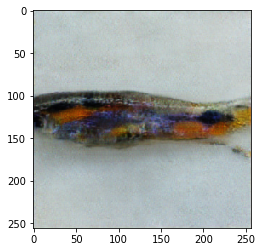

In [54]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [ ]:
label = 1
noise_label = np.zeros((1, num_labels))
noise_label[:,label] = 1
noise_codes = 


noise_input = np.random.uniform(-1., 1., size=[1, 100])
label = []
generator.predict(noise_input)